## TOC:
* [Import data and libraries](#import)
* [Preprocessing](#preprocessing)
    * [Strategy](#strategy)
    * [Feature engineering](#feature_engineering)
    * [Categorical features](#categorical)
    * [Continuous features](#continuous)
    * [Outliers detection](#outliers)
    * [Missing values](#missing)

* [Unsupervised learning](#unsupervised)
    * [Clustering]
    
* [Feature selection](#feature_selection)
    * [Multicollinearity Analysis](#multicollinearity)
    * [Individual tests]()

# Import data and libraries <a class="anchor" id="import"></a>

In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

# Team toolbox
from feature_engineering.categorical import one_hot_embarked, one_hot_name, handle_cabin, process_ticket
from feature_engineering.missing_values import missing_values_table
from feature_engineering.continuous import continuous_features, basic_preprocessing, outliers_handling

In [2]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Remove duplicate index
test['Survived'] = -1*np.ones(test.shape[0])
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,-1.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,-1.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,-1.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,-1.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,-1.0


# First Overview of Missing Values

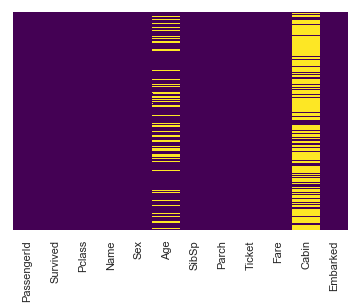

In [3]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Preprocessing

## Strategy

- <b>Missing values:</b> There are several variables (Age, Cabin) for which there are missing values. If not taken care of, this will have a detrimental effect on building predictive models. Some kind of models indeed need no missing values. However, we will not fill them right away, but instead wait for the preprocessing of other variables. The reason we proceed this way is some imputers work by looking at other features to complete the missing values (the kNN imputer is an example of such imputers). 

- <b>Categorical variables:</b> Some predictors are not suited for direct exploitation. For instance, variables like Name need feature engineering/extracting. We will therefore proceed with common sense and data-driven choices to create relevant features from these raw data. The features concerned are: Name, Cabin and Ticket.

- <b>Continuous variables:</b> Variables like Age need some transformation before being used by a Machine Learning model. Specifically, the data need to be scaled (standard/min-max scaler). Furthermore, we will be looking for relevant data transformation (such as log transform) to further make the information digestable by ML models.

In [4]:
# Train test split
X_train, y_train = train.drop(['Survived'], axis = 1), train['Survived']
print('Shape of the training set ' + str(X_train.shape))

Shape of the training set (891, 11)


## Encoding categorical features

Several features cannot be exploited right away. It is the case for the name, the cabin and the ticket of each passenger. We will therefore have to retrieve informations and perform sound feature engineering of the data.

### Name

<b>Titles:</b> After a careful analysis of the Name features, we observe the occurence of titles in lots of samples (Mr, Mrs, Lady, Dr, ...). These socio-economic markers probably have an importance. For instance, Lady and Countess might have a higher likelihood of getting on a lifeboat because of their status. The exhaustive list of found titles is: Jonkheer, Ms, Mlle, Mme, Capt, Don, Major, Col, Sir, Dona, Lady, the Countess. We will therefore parse the names and retrieve those keywords.

As we wee, most of the titles beside Mr, Mrs, Miss and Master have very low occurences. As the most common way to deal with such categorical features is to create dummy variables, the resulting imbalanced features will undermine Machine Learning models abilities to learn. We will therefore group some under broader categories:

- Ms, Mlle -> Miss (Obvious)
- Mme -> Mrs (Obvious)
- Jonkheer, Sir, Dona, Lady, the Countess -> Nobles (Jonkheer denotes the lowest rank within the nobility in the Low countries)
- Capt, Don, Major, Col -> Military (Military individuals are likely to help others when the ship is sinking, i.e. sense of duty)

After an attentive analysis of the barplot above, we see that following:

- Almost all nobles survived.
- Military and Reverents did not survive for the majority and the same goes for the doctors. 
It might be possible 

<b>Remark:</b> These features are highly correlated with the Sex of the individual. 'Military', 'Reverents' and 'Doctors' are all males (except for one female doctor).

Rev and Nobles seem to be strong indicators of survivorship. We will consequently retain them in our dataset. However, despite the above average survival likelihood, military titles and Doctors do not seem discriminative enough. We therefore group the two of them under 'Officer' (by lack of a better name).

A simple look at the above barplot tells us that there is an inverse proportionality between the number of names and the survival likelihood.
An inspection of the (rare) samples and the plot, we will group the number of names into the following category:
- Low: Up to 5
- Middle: 6 to 8
- High: 9 or more

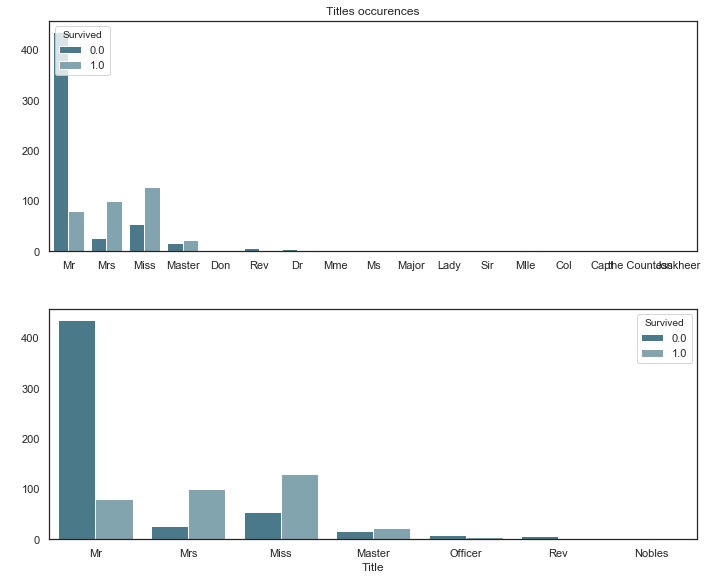

In [5]:
train, test = one_hot_name(train, test, plot = True)

In [6]:
train.columns.values

array(['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'], dtype=object)

# Embarked

The embarked feature defines the port of embarkation. There are two missing values, which we will replace by the most common port of Embarkation 'S'.

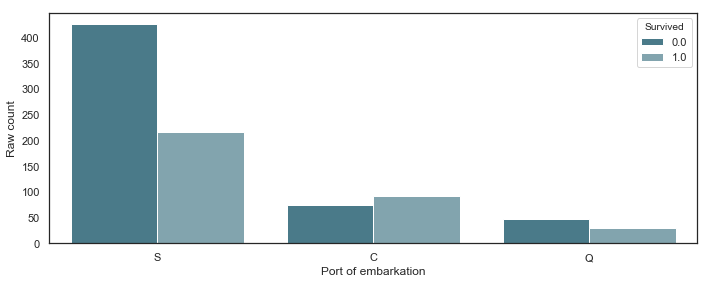

In [7]:
train, test = one_hot_embarked(train, test, plot = True)

## Cabin

The cabin number is a tricky predictor as it has many missing values and is not directly usable. Furthermore it needs feature engineering. We should note that there are some samples with more than one cabin reservation. Intuitively, the residents of the cabin are likely to know each other, or at least the person who bought the ticket. It is also likely that people who know each other tend to stick together when in distess. We will take this into account in the following analysis.

We will create the following features:

<b>Deck:</b> First letter of the string, it corresponds to the floor of the titanic, as per the plan below.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/687px-Titanic_cutaway_diagram.png" width="240" height="240" align="center"/>

We observe a few things:

- Some categories don't have enough informations and should therefore be merged together
- There are different likelihood of survival depending on the category

We will choose the groups based on the likelihood of survival

- T, GF, U - > Low (0 to 30% likelihood)
- A, C, G -> Medium (between 30% and 70% likelihood)
- EF, F, D, E -> High (superior to 70 %)

<b>Cabin number:</b> According to [this plan](https://www.encyclopedia-titanica.org/titanic-deckplans/c-deck.html) of the deck, the number is distributed with regards to the boat length (low numbers at the front of the boat and high ones at the end). We will consider the room number as a continuous variables. It will make our task easier for both the preprocessing and the the imputation.

<b>Number of cabins:</b>  A careful inspection of the number of cabins vs survival likelihood shows that people with more than two cabin have a higher survival rate. We add a Boolean variable that indicates wether the reservation has two cabins or more.

Age             float64
Fare            float64
Parch             int64
PassengerId       int64
Pclass            int64
Sex              object
SibSp             int64
Survived        float64
Ticket           object
Title_Master      uint8
Title_Miss        uint8
Title_Mr          uint8
Title_Mrs         uint8
Title_Rare        uint8
Embarked_C        uint8
Embarked_Q        uint8
Embarked_S        uint8
Deck_High         uint8
Deck_Low          uint8
Deck_Medium       uint8
NumberCabins      int64
Room            float64
RoomSide        float64
dtype: object


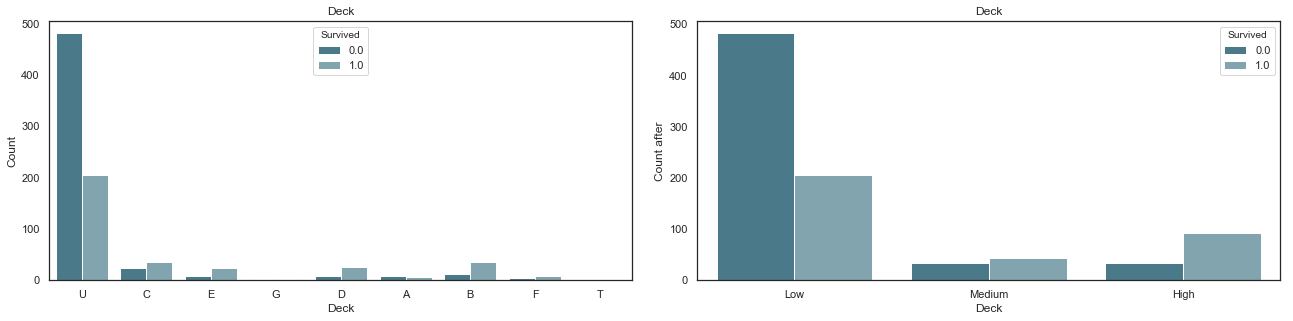

In [8]:
train, test = handle_cabin(train, test, plot = True)
print(train.dtypes)

## Ticket

We omit this feature for now.

In [ ]:
#train = process_ticket(train)

## Basic feature engineering

The two ordinal features Parch and SibSp both correspond to the number of family individuals. We will therefore merge the two by summing them into a new feature: 'Family'.

# Continuous features

There are several continuous variables that need special attention. These features are the Age, the Fare, and the Room number. In particular, we will explore transformation and scaling.

In [9]:
train, test = basic_preprocessing(train, test)

In [10]:
train.head()

,Age,Fare,PassengerId,Pclass,Sex,Survived,Ticket,Title_Master,Title_Miss,Title_Mr,...,Embarked_Q,Embarked_S,Deck_High,Deck_Low,Deck_Medium,NumberCabins,Room,RoomSide,Family,IsAlone
0,22.0,7.2500,1,3,1,0.0,A/5 21171,0,0,1,...,0,1,0,1,0,0,NaN,NaN,2,0
1,38.0,71.2833,2,1,0,1.0,PC 17599,0,0,0,...,0,0,0,0,1,0,85.0,1.0,2,0
2,26.0,7.9250,3,3,0,1.0,STON/O2. 3101282,0,1,0,...,0,1,0,1,0,0,NaN,NaN,1,1
3,35.0,53.1000,4,1,0,1.0,113803,0,0,0,...,0,1,0,0,1,0,123.0,1.0,2,0
4,35.0,8.0500,5,3,1,0.0,373450,0,0,1,...,0,1,0,1,0,0,NaN,NaN,1,1


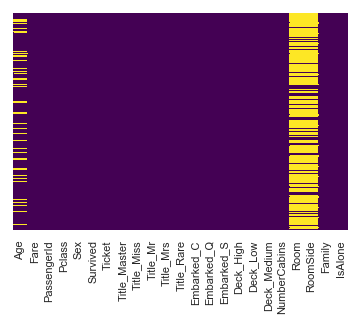

In [11]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
train, test = continuous_features(train, test)

## Age and Fare
Beside scaling, no apparent transformation needs to be made (age is approximately Gaussian distributed). 
We choose to log-transform the 'Fare' feature because it is highly right skewed.

## Missing values



In [ ]:
# Predictor / response split
X_train, y_train = train.drop(['Survived', 'PassengerId'], axis = 1), train['Survived']
X_test, y_test = test.drop(['Survived', 'PassengerId'], axis = 1), test['Survived']

In [ ]:
X_train.columns.values

In [ ]:
#from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

# Iterative Imputer
#imputer = IterativeImputer()
#X_train_cleaned = imputer.fit_transform(X_train)
#X_train_cleaned = pd.DataFrame(data = X_train_cleaned, columns = X_train.columns)

#X_test_cleaned = imputer.transform(X_test)
#X_test_cleaned = pd.DataFrame(data = X_test_cleaned, columns = X_test.columns)

In [ ]:
X_test_cleaned.columns

In [ ]:
X_train.dtypes

## Outliers detection

In [ ]:
X_train_cleaned, X_test_cleaned = outliers_handling(X_train_cleaned, X_test_cleaned)

## Outlier Analysis

In [ ]:
idx_isof = X_train_cleaned.loc[X_train_cleaned['isof_score'] < -0.56].index
idx_lof = X_train_cleaned.loc[X_train_cleaned['lof_score'] < -25].index

In [ ]:
idx_lof

In [ ]:
X_train_cleaned = X_train_cleaned.drop(idx_isof.intersection(idx_lof), axis = 0)
y_train = y_train.drop(idx_isof.intersection(idx_lof), axis = 0)

# Feature selection

In [ ]:
#fisher = fisher_score(train.drop(['Survived'], axis = 1).select_dtypes(include = 'uint8'), train['Survived'])

In [ ]:
#zip(train.drop(['Survived'], axis = 1).select_dtypes(include = 'uint8').columns.values, fisher)

# Multicollinearity Analysis

Linear based models suffer from multicollinearity. 

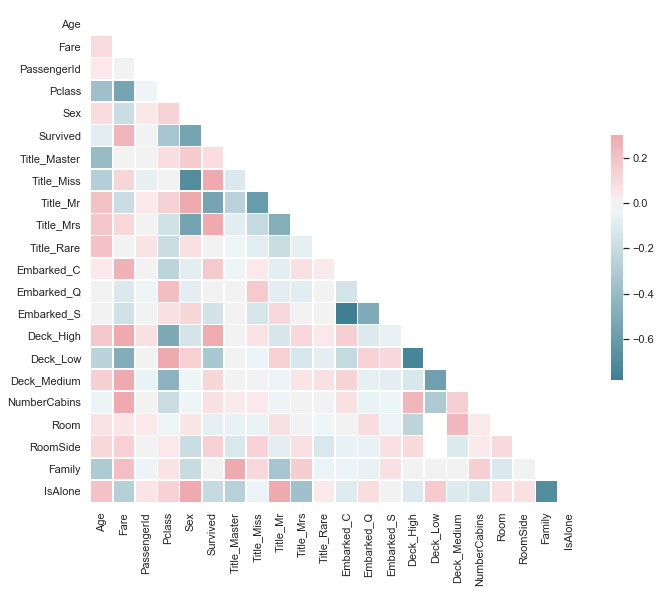

In [12]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,\
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Comments

Quick comments can be made about the above multicollinearity matrix. For instance, NumberNames_Low and NumberNames_Medium are high

- High collinearity:
    * NumberNames_Low and NumberNames_Medium (we fuse the two together)
    * Embarked_C cand Enbarked_S are as well hihly linked.
    * 
- No collinearity
    * Title_Rev has zero collinearity with 


In [ ]:
X_train_cleaned['Family']

# Feature selection



In [ ]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X_train_cleaned, y_train)

In [ ]:
rankings_rfe = dict(zip(X_train_cleaned.columns.values, selector.ranking_))
#predictors_rfe = list({k for (k,v) in rankings_rfe.items() if v<20})

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train_cleaned, y_train)

In [ ]:
rankings_clf = dict(zip(X_train_cleaned.columns.values, clf.feature_importances_))
def select_k_lowest(columns, clf, k = 10):
    idx = np.argpartition(clf.feature_importances_, -20)
    return(columns[idx[:k]])

#predictors_clf = list({k for (k,v) in rankings_clf.items() if v > 0.01})
predictors_clf = select_k_lowest(X_train_cleaned.columns.values, clf)
predictors_clf = select_k_lowest(X_train_cleaned.columns.values, clf)

In [ ]:
predictors_clf

In [ ]:
X_train_cleaned

In [ ]:
X_train_cleaned.columns.values

# Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
# Iterate over models
models = []

models.append(("LogisticRegression", LogisticRegression()))
models.append(("SVC", SVC()))
models.append(("LinearSVC", LinearSVC()))
models.append(("KNeighbors", KNeighborsClassifier()))
models.append(("DecisionTree", DecisionTreeClassifier()))
models.append(("RandomForest", RandomForestClassifier()))
rf2 = RandomForestClassifier(n_estimators=100, criterion='gini',
                                max_depth=10, random_state=0, max_features=None)
models.append(("RandomForest2",rf2))
models.append(("MLPClassifier",MLPClassifier(solver='lbfgs', random_state=0)))

results = []
names = []
for name, model in models:
    result = cross_val_score(model, X_train_cleaned, y_train,  cv=3)
    model.fit(X_train_cleaned, y_train)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

In [ ]:
X_train_cleaned['Sex'].head()

# Kaggle

In [ ]:
models_chosen = [models[k] for k in range(0, 8) if models[k][0] in ['LogisticRegression', 'SVC', 'RandomForest']]

In [ ]:
submission = [None]*3

for i, model in enumerate(models_chosen):
    predictions = model[1].predict(X_test_cleaned[predictors_rfe])
    #Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
    submission[i] = pd.DataFrame({'PassengerId':pd.RangeIndex(892, 892 + 418), 'Survived':predictions})

    name = '~/Desktop/' + model[0] + '.csv'
    submission[i].to_csv(name, index=False)

In [ ]:
pd.read_csv('~/Desktop/LogisticRegression.csv')

In [ ]:
submission.shape

# Sources
- [Feature Engineering 1 - Python](http://www.ultravioletanalytics.com/blog/kaggle-titanic-competition-part-iv-derived-variables)
- [Feature Engineering 2 - R](https://trevorstephens.com/kaggle-titanic-tutorial/r-part-4-feature-engineering/)
https://www.kaggle.com/ailuropus/extracting-family-relationships-on-titanic-sibsp